## Aim 1 - Recreate Figure 2 from Alleman et al

Figure 2 from [Alleman et al](pmc.ncbi.nlm.nih.gov/articles/PMC8686835/) shows experimental vs predicted growth rate of _Azobacter vinelandii_ under different oxygen concentrations and sucrose uptake rates. Panel a shows the predicted rates when using the partially-coupled branch of the electron transport system for ATPM flux determination, and panel b shows the rates under the fully-coupled branch.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cobra

In [2]:
# load data (downloaded from Alleman et al)
table_s2 = pd.read_excel('./data/alleman_table_s2.xlsx', index_col=0)
original_model = cobra.io.load_json_model('./data/iAA1300_C.json')
model = original_model.copy()

In [3]:
# view data format
table_s2.head()

,Sucrose_uptake_gcdw,O2_conc,ATPM_pred,ETS_path,Growth_rate_exp,Growth_rate_pred,Oxygen_consumption_pred,ATP_production,ATPM_ATP_prect,growth_yeild_suc_pred,growth_yeild_suc_exp,growth_yeild_o2_pred,growth_yeild_o2_exp
0,2.01,12,16.258129,NII_BD_F,0.06,0.094395,19.432741,39.352471,0.413141,46.962927,29.850746,4.857549,3.087573
1,2.24,12,16.258129,NII_BD_F,0.07,0.112532,21.292168,43.321077,0.375294,50.237446,31.250000,5.285130,3.287594
2,2.24,12,16.258129,NII_BD_F,0.10,0.112532,21.292168,43.321077,0.375294,50.237446,44.642857,5.285130,4.696563
3,2.40,12,16.258129,NII_BD_F,0.12,0.125149,22.585683,45.671348,0.355981,52.145209,50.000000,5.541055,5.313100
4,3.79,12,16.258129,NII_BD_F,0.18,0.234755,33.823092,69.296014,0.234619,61.940741,47.493404,6.940684,5.321808


In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.004845,0,0.00%
cl_e,EX_cl_e,0.004845,0,0.00%
cobalt2_e,EX_cobalt2_e,2.327E-05,0,0.00%
cu2_e,EX_cu2_e,0.00066,0,0.00%
fe2_e,EX_fe2_e,0.007682,0,0.00%
fe3_e,EX_fe3_e,0.007268,0,0.00%
glc__D_e,EX_glc__D_e,15,6,100.00%
h_e,EX_h_e,1.161,0,0.00%
k_e,EX_k_e,0.1817,0,0.00%
mg2_e,EX_mg2_e,0.008075,0,0.00%


### Data Processing
Extracting only the experimental data we care about from the provided table, as we want to make the predictions with the model ourselves.

ETS_path column is described [here](http://github.com/alexander-alleman/Azotobactervinelandii_metabolicmodel/blob/main/Notebooks/ETS_Maintenance_Energy.ipynb).

ATPM flux will be calculated via methodology described in the paper.
> ATP maintenance rate was determined by setting substrate uptake rate to the maintenance coefficient and increasing ATP maintenance reaction flux until growth rate reached zero.

> ...to determine the value of NGAM, the ATPM rate lower bound was increased until the growth reached zero, allowing all sucrose consumption to be allocated to NGAM... A specific ATPM flux was determined for each ETS branch under different O2 concentrations using the experimentally determined maintenance coefficient.

In [40]:
paths = ['NII_BD_R', 'NI_CO_R']
kos = [['NADH6', 'CYOO2pp', 'FIX'], ['NADH5', 'CYTBDpp', 'FIX']]
couplings = ['partial', 'full']

In [41]:
# Taken from Kuhla et al - https://doi.org/10.1007/BF00446753
maintenance_coeffs = [0.9, 4.4, 6.2, 7, 8]
o2_concs = [12, 48, 108, 144, 192]

In [73]:
atpm_dict = {}
for path, reacs, coupled in zip(paths, kos, couplings):
  model = original_model.copy()
  model.reactions.EX_glc__D_e.bounds = [0, 0]
  model.reactions.EX_nh4_e.bounds = [0, 0]
  for reac in reacs:
    model.reactions.get_by_id(reac).bounds = [0, 0]

  for o2_conc, maint in zip(o2_concs, maintenance_coeffs):
    model.reactions.EX_sucr_e.bounds = [-maint, -maint]

    # binary search atpm val
    low = 0
    high = 1000
    while True:
      mid = (low + high) / 2
      model.reactions.ATPM.bounds = [mid, 1000]
      res = model.optimize()
      if res.status == 'optimal':
        if res.objective_value < 0.00001:  # very small growth, but feasible
          atpm_dict[(coupled, o2_conc)] = res.fluxes['ATPM']
          break
        else:  # more growth than desired, increase maintenance
          low = mid
      else:  # not feasible, decrease maintenance
        high = mid
  

In [76]:
atpm_dict

{('partial', 12): 16.07513427734375,
 ('partial', 48): 78.5980224609375,
 ('partial', 108): 110.75210571289062,
 ('partial', 144): 125.04386901855469,
 ('partial', 192): 142.90809631347656,
 ('full', 12): 50.23193359375,
 ('full', 48): 245.59783935546875,
 ('full', 108): 346.0693359375,
 ('full', 144): 390.72418212890625,
 ('full', 192): 446.5446472167969}

In [78]:
exp_sucrose_rates = table_s2.groupby(['O2_conc', 'Sucrose_uptake_gcdw'], as_index=False).aggregate({'Growth_rate_exp': 'mean'})
exp_sucrose_rates = exp_sucrose_rates.set_index('O2_conc')
exp_sucrose_rates.head()

,Sucrose_uptake_gcdw,Growth_rate_exp
O2_conc,,
12,2.01,0.060
12,2.24,0.085
12,2.40,0.120
12,3.79,0.180
12,4.91,0.260


In [ ]:
pred_growth_rates_full = []
pred_growth_rates_partial = []
for o2_conc, row in exp_sucrose_rates.iterrows():
  break

In [ ]:
plotting_data = table_s2[['Growth_rate_exp', 'O2_conc', 'ATPM_pred', 'ETS_path']].copy()

In [ ]:
exp_data = table_s2[['Growth_rate_exp', 'O2_conc', 'ATPM_pred', 'ETS_path']].copy()
exp_data = exp_data[exp_data['ETS_path'].isin(['NII_BD_R', 'NI_CO_F'])]

In [ ]:
exp_data['Pathway'] = exp_data['ETS_path'].map(lambda p: 'partially coupled' if 'BD' in p else 'fully coupled')

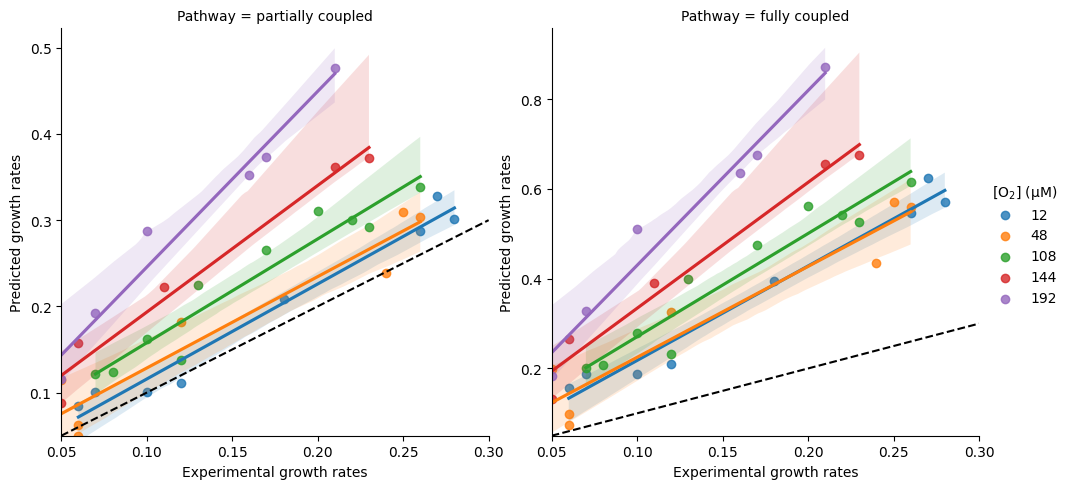

In [ ]:
xbounds = [0.05, 0.3]
fig = sns.lmplot(exp_data, x = 'Growth_rate_exp', y = 'Growth_rate_pred', 
                  hue = 'O2_conc', palette = sns.color_palette("tab10"), col = 'Pathway',
                  facet_kws = { 'xlim': xbounds, 'sharey': False })
x = np.linspace(*xbounds, 10000)
fig.legend.set_title("[O$_2$] ($\\mathrm{\\mu}$M)")
for ax in fig.axes.flat:
  ax.set_ylim([0.05, None])
  ax.set_xlabel('Experimental growth rates')
  ax.set_ylabel('Predicted growth rates')
  ax.plot(x, x, color='black', linestyle='--')